In [ ]:
"""
TEXTURE MAP VISUALIZATOR

can we extract the texture from an image? 

part of the neural style transfer project | see Fig 1 of the paper
"""
import torch
import torch.nn as nn
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use GPU 0

from torchvision import transforms
from PIL import Image
import numpy as np
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def load_image(img_path):
    image = Image.open(img_path).convert('RGB')
    print(type(image))
    img_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std= [0.229, 0.224, 0.225])
    ])
    return img_transform(image).unsqueeze(0)

def im_convert(tensor):
    image = tensor.clone().detach().cpu().squeeze(0)
    image = image.numpy().transpose(1, 2, 0)
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image = image.clip(0, 1)
    return image

In [ ]:
file_dir = '/home/rotakagui/projects/pytorch-neural-style-transfer'
content_img_path = os.path.join(file_dir, 'data', 'style', 'starry_night.jpg')
img = load_image(content_img_path).to(DEVICE)

<class 'PIL.Image.Image'>


In [ ]:
vgg_net = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True);
vgg_net.eval().to(DEVICE);
print(get_graph_node_names(vgg_net))



Using cache found in /home/rotakagui/.cache/torch/hub/pytorch_vision_v0.10.0
/home/rotakagui/miniconda3/envs/jupy/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rotakagui/miniconda3/envs/jupy/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'features.31', 'features.32', 'features.33', 'features.34', 'features.35', 'features.36', 'features.37', 'features.38', 'features.39', 'features.40', 'features.41', 'features.42', 'features.43', 'features.44', 'features.45', 'features.46', 'features.47', 'features.48', 'features.49', 'features.50', 'features.51', 'features.52', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6'], ['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4

In [262]:
model = create_feature_extractor(vgg_net,{'features.0':'conv1', 'features.5':'conv2', 'features.10':'conv3', 'features.19':'conv4', 'features.28':'conv5'})
print(type(model))

<class 'torch.fx.graph_module.GraphModule.__new__.<locals>.GraphModuleImpl'>


### Why Gram matrix? 

Textures are per definition stationary,
so a texture model needs to be agnostic to spatial information. A summary statistic that discards the spatial information in the feature maps is given by the correlations between the responses of different features.

### Gram matrix

$$
G^l_{ij}=\sum_k F_{ik}^l F_{jk}^l
$$

- $G^l \in R^{N_l \times N_l}$, where $G^l_{ij}$ is the inned product between feature map $i$ and $j$ in layer $l$.
- $F^l\in R^{N_l \times M_l}$, where $F^l_{jk}$ is the activation of the $j^{th}$ filter at position $k$ in layer $l$

In [ ]:
def GramMatrix(F):
    (dim, ch, h, w) = F.shape
    F = F.reshape(F.shape[1],-1)
    return torch.matmul(F,torch.transpose(F,0,1))#/(ch*h*w)

In [ ]:
with torch.no_grad():
    style_layers = [model(img)[f'conv{i}'].detach() for i in range(1,6)]
    style_gram   = [GramMatrix(mat) for mat in style_layers]
white_noise = torch.rand(size=img.shape, requires_grad=True, device=DEVICE)
N_l = [ch for _, ch, _, _ in (mat.shape for mat in style_layers)]
M_l = [W*H for _, _, W, H in (mat.shape for mat in style_layers)]


loss function = 1.5986054791028437e-07: 100%|██████████| 5000/5000 [02:29<00:00, 33.35it/s]


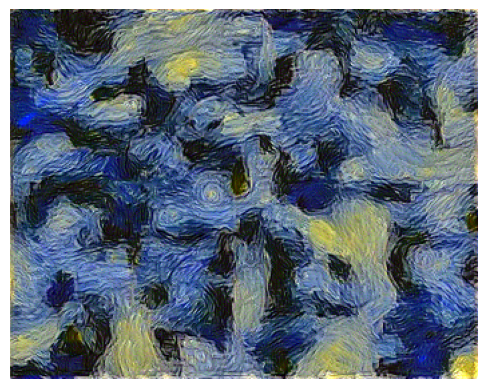

In [ ]:
# Optimization loop

epochs = 5000
optimizer = torch.optim.Adam([white_noise],lr=0.1)

for i in (t := trange(epochs)):
    
    out_layers = [model(white_noise)[f'conv{i}'] for i in range(1,6)]
    out_gram = [GramMatrix(mat) for mat in out_layers]
    

    foo = style_gram[0]-out_gram[0]
    cte = [torch.tensor(1/(4*(N_l[i]**2)*(M_l[i]**2))) for i in range(0,5)]
    loss = 0.0
    for i in range(0,5):
        loss += cte[i]*torch.nn.MSELoss(reduction='sum')(style_gram[i], out_gram[i])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    t.set_description(f'loss function = {loss}')

reconstructed_image = im_convert(white_noise)
reconstructed_image = Image.fromarray((reconstructed_image * 255).astype('uint8'))    
plt.imshow(reconstructed_image)
plt.axis('off')
plt.show()